In [1]:
from gvuln import *
import matplotlib.pyplot as plt
from time import time

torch.set_default_dtype(torch.float32)

## Encoding Exponential as a loop

In [24]:
noise_program = """
w1 = uniform([0, {}],5);
u1 = uniform([0, 1], 5);
expw1 = 0 - w1;
expw1 = _par*expw1;
expw1 = exp(expw1);
while u1 - expw1 > 0 {{
    w1 = uniform([0, {}], 5);
    u1 = uniform([0, 1], 5);
    expw1 = 0 - w1;
    expw1 = _par*expw1;
    expw1 = exp(expw1);
}} end while;
"""

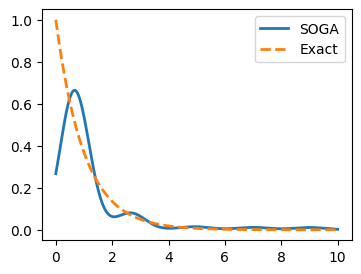

In [28]:
from torch.distributions import Exponential

M = 10
b = 1

current_noise = noise_program.format(M, M)

par = 1./b

plt.figure(figsize=(4, 3))

compiledFile=compile2SOGA_text(current_noise)
cfg = produce_cfg_text(compiledFile)
params_dict = {'par': torch.tensor(par, requires_grad=False)}
output_dist = start_SOGA(cfg, params_dict=params_dict)
noise_dist = extract_marginal(output_dist, ['w1'])
pruned_noise = ranking_prune(noise_dist, 100)

x = torch.linspace(0, M, 500).reshape(500, 1)
y_soga = noise_dist.gm.pdf(x).detach().numpy()

plt.plot(x.numpy(), y_soga, linewidth=2, label='SOGA')
plt.plot(x.numpy(), Exponential(par).log_prob(x).exp().detach().numpy(), '--', linewidth=2, label='Exact')
plt.legend()

#print(b_list[i], noise_dist.gm.mean(), torch.sqrt(noise_dist.gm.cov()), noise_dist.gm.n_comp())

150.0 tensor([129.3939]) tensor([[110.3915]]) 16
30.0 tensor([30.7389]) tensor([[32.0549]]) 14
15.0 tensor([15.3694]) tensor([[16.0275]]) 14
7.5 tensor([7.6847]) tensor([[8.0137]]) 14
3.0 tensor([3.0739]) tensor([[3.2055]]) 14
1.5 tensor([1.5369]) tensor([[1.6028]]) 14


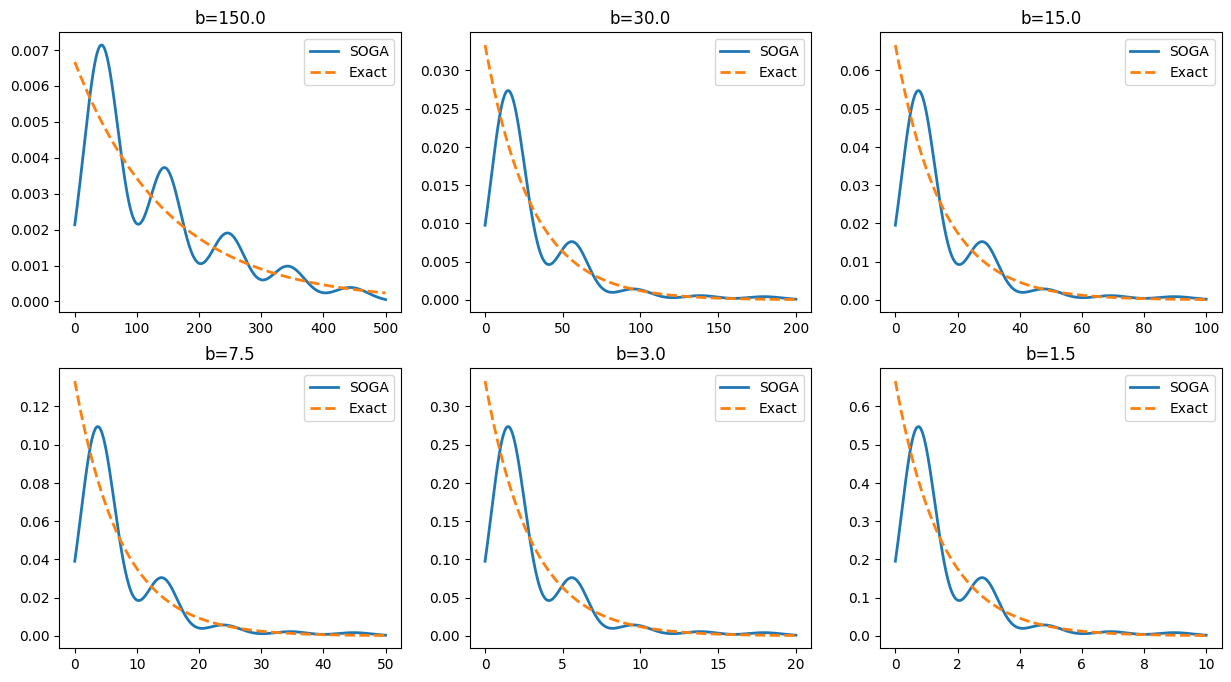

In [29]:
from torch.distributions import Exponential

M_list = [500, 200, 100, 50, 20, 10]
b_list = [150., 30., 15., 7.5, 3., 1.5]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i in range(len(M_list)):

    current_noise = noise_program.format(M_list[i], M_list[i])

    par = 1./b_list[i]

    compiledFile=compile2SOGA_text(current_noise)
    cfg = produce_cfg_text(compiledFile)
    params_dict = {'par': torch.tensor(par, requires_grad=False)}
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    noise_dist = extract_marginal(output_dist, ['w1'])
    pruned_noise = ranking_prune(noise_dist, 100)


    x = torch.linspace(0, M_list[i], 500).reshape(500, 1)
    y_soga = noise_dist.gm.pdf(x).detach().numpy()

    ax = axes.flat[i]
    ax.plot(x.numpy(), y_soga, linewidth=2, label='SOGA')
    ax.plot(x.numpy(), Exponential(par).log_prob(x).exp().detach().numpy(), '--', linewidth=2, label='Exact')
    ax.set_title(f"b={b_list[i]}")
    ax.legend()

    print(b_list[i], noise_dist.gm.mean(), torch.sqrt(noise_dist.gm.cov()), noise_dist.gm.n_comp())

## Encoding Laplace as a double loop

In [9]:
1+(np.exp(-20)-1)/20

np.float64(0.9500000001030576)

In [4]:
noise_program = '''
    /* First exponential (approximated via i.i.d. loop semantics) */
    w1 = uniform([0, {}], 5);
    u1 = uniform([0, 1], 2);
    expw1 = 0 - w1;
    expw1 = _par*expw1;
    expw1 = exp(expw1);
    while u1 - expw1 > 0 {{
        w1 = uniform([0, {}], 5);
        u1 = uniform([0, 1], 2);
        expw1 = 0 - w1;
        expw1 = _par*expw1;
        expw1 = exp(expw1);
    }} end while;
    /* Second exponential (approximated via i.i.d. loop semantics) */
    w2 = uniform([0, {}], 5);
    u2 = uniform([0, 1], 2);
    expw2 = 0 - w2;
    expw2 = _par*expw2;
    expw2 = exp(expw2);
    while u2 - expw2 > 0 {{
        w2 = uniform([0, {}], 5);
        u2 = uniform([0, 1], 2);
        expw2 = 0 - w2;
        expw2 = _par*expw2;
        expw2 = exp(expw2);
    }} end while;
    /*Transforms into Laplace */
    r = w1 - w2;
    '''

150.0 tensor([0.0019]) tensor([[152.1764]]) 50
30.0 tensor([-4.9174e-06]) tensor([[56.2906]]) 50
15.0 tensor([-2.9132e-06]) tensor([[28.1453]]) 50
7.5 tensor([-1.4901e-06]) tensor([[14.0727]]) 50
3.0 tensor([-4.5542e-07]) tensor([[5.6291]]) 50
1.5 tensor([-3.2037e-07]) tensor([[2.8145]]) 50


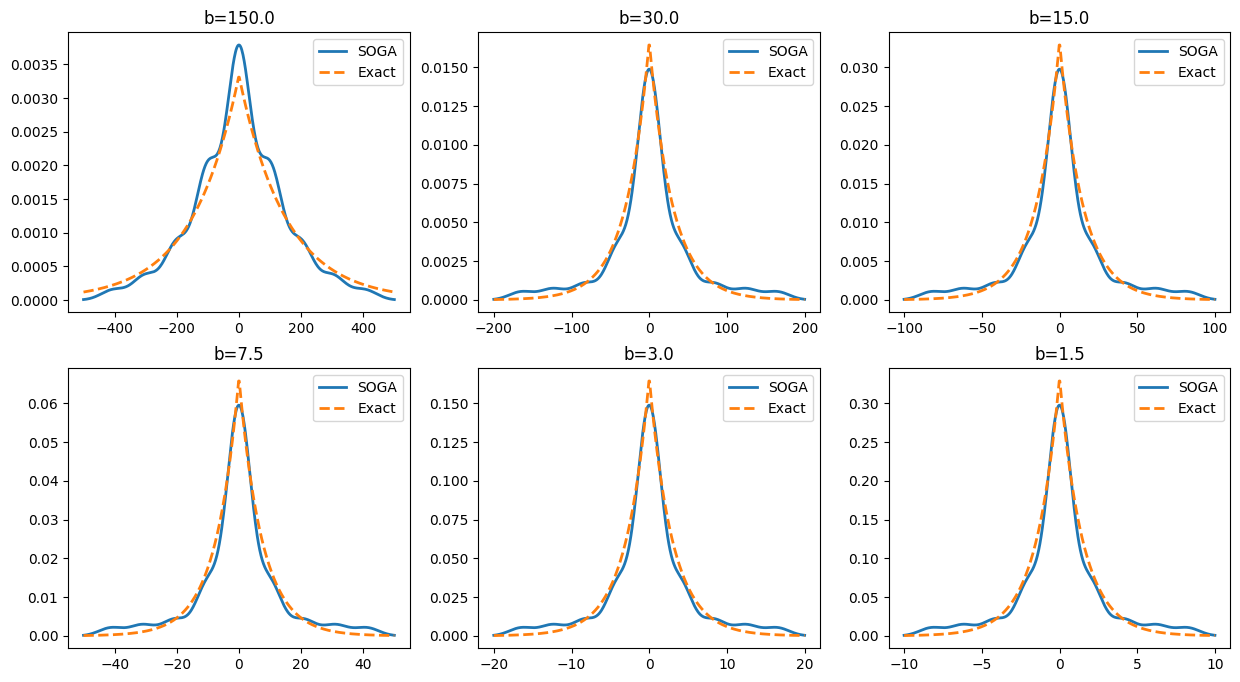

In [5]:
from torch.distributions import Laplace

M_list = [500, 200, 100, 50, 20, 10]
b_list = [150., 30., 15., 7.5, 3., 1.5]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i in range(len(M_list)):

    current_noise = noise_program.format(M_list[i], M_list[i], M_list[i], M_list[i])

    par = 1./b_list[i]

    compiledFile=compile2SOGA_text(current_noise)
    cfg = produce_cfg_text(compiledFile)
    params_dict = {'par': torch.tensor(par, requires_grad=False)}
    output_dist = start_SOGA(cfg, params_dict=params_dict)
    noise_dist = extract_marginal(output_dist, ['r'])
    pruned_noise = ranking_prune(noise_dist, 50)


    x = torch.linspace(-M_list[i], M_list[i], 500).reshape(500, 1)
    y_soga = noise_dist.gm.pdf(x).detach().numpy()

    ax = axes.flat[i]
    ax.plot(x.numpy(), y_soga, linewidth=2, label='SOGA')
    ax.plot(x.numpy(), Laplace(0, 1./par).log_prob(x).exp().detach().numpy(), '--', linewidth=2, label='Exact')
    ax.set_title(f"b={b_list[i]}")
    ax.legend()

    print(b_list[i], noise_dist.gm.mean(), torch.sqrt(noise_dist.gm.cov()), noise_dist.gm.n_comp())

## Encoding Gamma as a double loop

In [6]:
noise_program = '''
    /* First exponential (approximated via i.i.d. loop semantics) */
    w1 = uniform([0, 10], 5);
    u1 = uniform([0, 1], 2);
    expw1 = 0 - w1;
    expw1 = exp(expw1);
    while u1 - expw1 > 0 {
        w1 = uniform([0, 10], 5);
        u1 = uniform([0, 1], 2);
        expw1 = 0 - w1;
        expw1 = exp(expw1);
    } end while;  
    /* Second exponential (approximated via i.i.d. loop semantics) */
    w2 = uniform([0, 10], 5);
    u2 = uniform([0, 1], 2);
    expw2 = 0 - w2;
    expw2 = exp(expw2);
    while u2 - expw2 > 0 {
        w2 = uniform([0, 10], 5);
        u2 = uniform([0, 1], 2);
        expw2 = 0 - w2;
        expw2 = exp(expw2);
    } end while;
    /* Transforms into Gamma(2,_rate) */  
    r = w1 + w2;
    r = _rate*r;
    '''

150.0 tensor([32.2817]) tensor([[30.5994]]) 84
30.0 tensor([6.4563]) tensor([[6.1199]]) 84
15.0 tensor([3.2282]) tensor([[3.0599]]) 84
7.5 tensor([1.6141]) tensor([[1.5300]]) 84
3.0 tensor([0.6456]) tensor([[0.6120]]) 84
1.5 tensor([0.3228]) tensor([[0.3060]]) 84


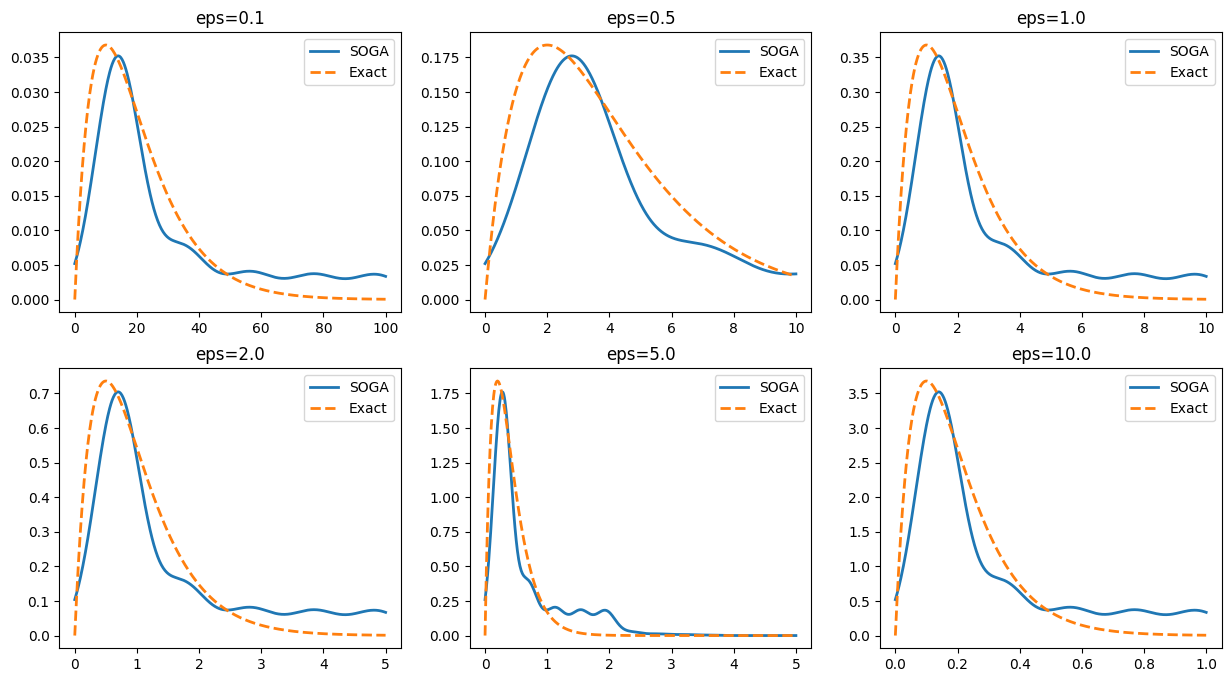

In [7]:
from torch.distributions import Laplace

eps_list = [0.1, 0.5, 1., 2., 5., 10.]
M_list = [100, 10, 10, 5, 5, 1]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for i in range(len(eps_list)):

   eps = torch.tensor(eps_list[i])

   current_noise = noise_program
   compiledFile=compile2SOGA_text(current_noise)
   cfg = produce_cfg_text(compiledFile)
   params_dict = {'rate': torch.tensor(1./eps.item(), requires_grad=False)}
   output_dist = start_SOGA(cfg, params_dict=params_dict)
   noise_dist = extract_marginal(output_dist, ['r'])
   pruned_noise = ranking_prune(noise_dist, 100)
   x = torch.linspace(0, M_list[i], 500).reshape(500, 1)
   y_soga = noise_dist.gm.pdf(x).detach().numpy()
   ax = axes.flat[i]
   ax.plot(x.numpy(), y_soga, linewidth=2, label='SOGA')
   ax.plot(x.numpy(), Gamma(2., eps).log_prob(x).exp().detach().numpy(), '--', linewidth=2, label='Exact')
   ax.set_title(f"eps={eps_list[i]}")
   ax.legend()
   print(b_list[i], noise_dist.gm.mean(), torch.sqrt(noise_dist.gm.cov()), noise_dist.gm.n_comp())